In [2]:
import pickle

import warnings
import time
import re
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go


from transformers import BertTokenizer, BertModel
import torch


from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap

from umap import UMAP

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, accuracy_score



RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


sns.set_theme(style="white")

pd.options.display.max_rows = 1024
pd.options.display.max_columns = 1024
pd.set_option("display.max_colwidth", 128)


# Warnings
warnings.filterwarnings("ignore")


# bert_model = BertModel.from_pretrained(
#     "bert-base-cased",
#     output_hidden_states=True).to(DEVICE)
# tokenizer = BertTokenizer.from_pretrained("bert-base-cased")


bert_model = BertModel.from_pretrained(
    "DeepPavlov/rubert-base-cased",
    output_hidden_states=True).to(DEVICE)
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

Device: cpu


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
pip install --upgrade certifi

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
pip install --upgrade requests

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [5]:
pip install numpy==1.24

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [6]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [7]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [8]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [9]:
import kaleido

In [10]:
def plot_continious_hist(data, feature, hue=None, bins=100, figsize=(800, 500)):
    if hue is not None:
        data = data.sort_values(by=hue)
        
    hist_fig = px.histogram(
        data,
        x=feature,
        color=hue if hue is not None else None,
        nbins=bins,
        marginal="box",
        opacity=0.8)
    hist_fig.update_layout(
        title=f"{feature} distribution",
        plot_bgcolor='white',
        bargap=0.2,
        width=figsize[0],
        height=figsize[1],
        yaxis_title='Amount')
    
    hist_fig.show()
    
    
def plot_continious_ecdf(data, feature, hue=None, bins=100, figsize=(800, 500)):
    if hue is not None:
        data = data.sort_values(by=hue)
        
    ecdf_fig = px.ecdf(
        data,
        x=feature,
        color=hue if hue is not None else None,
        opacity=0.8)
    ecdf_fig.update_layout(
        title=f"{feature} ECDF",
        plot_bgcolor='white',
        bargap=0.2,
        width=figsize[0],
        height=figsize[1],
        yaxis_title='Probability')
    
    ecdf_fig.show()
    
    
def plot_continious_agg_dinamics(data, feature, date, hue=None,
                                 aggfunc="mean", figsize=(800, 500)):
    index = [date] if hue is None else [date, hue]
    tmp = data.pivot_table(index=index, values=feature, aggfunc=aggfunc).reset_index()
    tmp[date] = tmp[date].astype("string")

    fig = px.line(
        tmp,
        x=date,
        y=feature,
        color=hue if hue is not None else None,
        markers=True)
    fig.update_layout(
        title=f'Average dinamics - Feature: {feature}',
        xaxis_title=date,
        yaxis_title=feature,
        showlegend=True,
        width=figsize[0],
        height=figsize[1],
        plot_bgcolor='white'
    )
    
    fig.show()
    
    
def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))

    return "Completed for {0:02d}:{1:02d}:{2:02d}".format(h, m, s)


def extract_text_vectors(df, column, model, tokenizer,
                         device, verbose=True, verbose_interval=100):
    df = df.copy()
    model = model.to(device)
    if verbose:
        start = time.time()
        total_images = df.shape[0]
        _ = 0

    vectors = []
    for index, row in df.reset_index(drop=True).iterrows():
        index += 1
        text = row[column]
        input_ids = torch.tensor(
            [tokenizer.encode(text, add_special_tokens=True)]).to(device)
        with torch.no_grad():
            model_output = model(input_ids)
        vectors.append(
            model_output.last_hidden_state.mean(dim=1).squeeze().tolist())

        if verbose and (index % verbose_interval == 0 or index == total_images - 1):
            print(f"{_}. Processed text {index}/{total_images}.")
            _ += 1

    assert all(len(vector) == len(vectors[0]) for vector in vectors), "Text vectors have different dimensions"

    vectors_np = np.array(vectors)
    df[[f"text_vector_el{x}"
        for x in range(len(vectors_np[0]))]] = vectors_np

    if verbose:
        end = time.time()
        print(f"Extraction completed successfully. {exec_time(start, end)}\n")

    return df


def plot_reduced_ds(data, hue, n_components):
    if n_components == 2:
        fig = px.scatter(
            data,
            x=0,
            y=1,
            color=hue,
            # text="utterance",
            title='Dataset 2D projection',
#             width=3200, # 3840×2160
#             height=1800
        )
    else:
        fig = px.scatter_3d(
            data,
            x=0,
            y=1,
            z=2,
            color=hue,
            # text="utterance",
            title='Dataset 3D projection',
            width=1280,
            height=720
        )

    fig.update_layout(plot_bgcolor='white')
    fig.show()

In [11]:
import pandas as pd

data = pd.read_csv(r'C:\Users\sumit\OneDrive\Documents\mp_project\customer_support.csv.')

data["response_length"] = data["response"].replace(" ", "").apply(lambda x: len(x))

print(data.info())
print()
data.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   query            78 non-null     object
 1   response         78 non-null     object
 2   response_length  78 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.0+ KB
None



,query,response,response_length
0,My order hasn't arrived yet.,We apologize for the inconvenience. Can you please provide your order number so we can investigate?,99
1,I received a damaged product.,We apologize for the inconvenience. Can you please provide a photo of the damaged product so we can assist you further?,119
2,I need to return an item.,"Certainly. Please provide your order number and reason for return, and we will provide you with instructions on how to proceed.",127


In [12]:
plot_continious_hist(data, "response_length")
data["response_length"].describe()

count     78.000000
mean     126.551282
std       21.192162
min       75.000000
25%      115.750000
50%      127.000000
75%      139.750000
max      168.000000
Name: response_length, dtype: float64

In [13]:
pip install pymorphy2

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [14]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import sent_tokenize, word_tokenize
# from nltk.stem import WordNetLemmatizer

# import pymorphy2

# nltk.download('punkt')
# nltk.download('stopwords')

# morph = pymorphy2.MorphAnalyzer()
# STOP_WORDS = set(stopwords.words('english'))

# def get_wordnet_pos(treebank_tag):
#     if treebank_tag.startswith('J'):
#         return 'a'  # adjective
#     elif treebank_tag.startswith('V'):
#         return 'v'  # verb
#     elif treebank_tag.startswith('N'):
#         return 'n'  # noun
#     elif treebank_tag.startswith('R'):
#         return 'r'  # adverb
#     else:
#         return 'n'  # set noun by default


# def tokenize_text(text):
#     sentences = sent_tokenize(text)
#     tokens = []
#     for sentence in sentences:
#         sentence_tokens = word_tokenize(sentence)
#         sentence_tokens = [token for token in sentence_tokens if token not in STOP_WORDS]
#         lemmas = [morph.parse(token)[0].normal_form for token in sentence_tokens]
#         tokens.extend(lemmas)
#     return ' '.join(tokens)

In [15]:
import pandas as pd

data["response"].fillna("", inplace=True)

texts = data["response"]

texts = (pd.DataFrame(texts))
vectors = extract_text_vectors(
    texts,
    "response",
    bert_model,
    tokenizer,
    DEVICE,
    verbose_interval=1000
)


%%time

texts = data["response"]

texts = (pd.DataFrame(texts))
vectors = extract_text_vectors(
    texts,
    "response",
    bert_model,
    tokenizer,
    DEVICE,
    verbose_interval=1000
)

# tokens = texts.apply(tokenize_text)
# vectors = TfidfVectorizer().fit_transform(tokens)

# display(tokens.head())
# print()
vectors.head()

0. Processed text 77/78.
Extraction completed successfully. Completed for 00:00:22



UsageError: Line magic function `%%time` not found.


In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [17]:
%%time

vectors["Preference"] = KMeans(
    n_clusters=3, random_state=42).fit_predict(vectors.drop("response", axis=1))

CPU times: total: 328 ms
Wall time: 505 ms


In [18]:
n_components = 2
reducer = UMAP(n_components=n_components, n_neighbors=400)
# UMAP, TSNE, PCA, KernelPCA, LocallyLinearEmbedding, Isomap

scaler = MinMaxScaler()

In [19]:
%%time

X = vectors.drop(["response", "Preference"], axis=1)
y = data["query"]
y_2 = vectors["Preference"]

if scaler is not None:
    X = scaler.fit_transform(X)


reduced_ds = pd.DataFrame(reducer.fit_transform(X))
reduced_ds = pd.concat([reduced_ds, y], axis=1)
reduced_ds = pd.concat([reduced_ds, texts], axis=1)
reduced_ds = pd.concat([reduced_ds, vectors["Preference"]], axis=1)

reduced_ds["Preference"] = reduced_ds["Preference"].astype("object")

reduced_ds

CPU times: total: 4.77 s
Wall time: 12.6 s


,0,1,query,response,Preference
0,-1.909342,12.287382,My order hasn't arrived yet.,We apologize for the inconvenience. Can you please provide your order number so we can investigate?,1
1,-1.085459,11.410000,I received a damaged product.,We apologize for the inconvenience. Can you please provide a photo of the damaged product so we can assist you further?,1
2,0.285225,10.568338,I need to return an item.,"Certainly. Please provide your order number and reason for return, and we will provide you with instructions on how to proceed.",0
3,-2.119059,12.587050,I want to change my shipping address.,No problem. Can you please provide your order number and the new shipping address you'd like to use?,1
4,-2.743788,12.350836,I have a question about my bill.,We'd be happy to help. Can you please provide your account number and a brief description of your question?,1
5,-2.567775,11.088795,How do I cancel my subscription?,We're sorry to hear that. Can you please provide your account email and the name of the subscription you'd like to cancel?,1
6,0.375237,10.297904,Can I get a refund for my purchase?,We understand your concern. Please provide your order number and the reason for your refund request so we can assist you fur...,0
7,-1.826753,12.787419,I'd like to track my order.,Of course. Can you please provide your order number so we can check the current status for you?,1
8,-1.550835,11.213137,My account has been locked.,We apologize for the inconvenience. Can you please provide your account email so we can help you regain access?,1
9,-2.463039,11.039510,I can't find the item I'm looking for.,We're here to help. Can you please provide a description or product name of the item you're looking for so we can assist you?,1


In [20]:
plot_reduced_ds(reduced_ds, "query", n_components)

In [21]:
plot_reduced_ds(reduced_ds, "Preference", n_components)

In [22]:
y_2 = OrdinalEncoder().fit_transform(pd.DataFrame(y_2)) # pd.get_dummies(y, drop_first=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_2, test_size=0.25, random_state=RANDOM_STATE)

if scaler is not None:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

# X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
# X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
# y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
# y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

print('The shape of the training set for independent features:  ',
      X_train.shape)
print('The shape of the training set for target:                ',
      y_train.shape)
print()
print('The shape of the test set for independent features:      ',
      X_test.shape)
print('The shape of the test set for target:                    ',
      y_test.shape)

The shape of the training set for independent features:   (58, 768)
The shape of the training set for target:                 (58, 1)

The shape of the test set for independent features:       (20, 768)
The shape of the test set for target:                     (20, 1)


In [23]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [24]:
model_ann = Sequential()

model_ann.add(Dense(units=149, activation='relu', input_dim=X_train.shape[1]))
model_ann.add(Dense(units=55, activation='relu'))
model_ann.add(Dense(units=y_2.shape[1], activation='softmax'))

model_ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ann.summary()


model_ann = LogisticRegression(multi_class="multinomial")



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 149)               114581    
                                                                 
 dense_1 (Dense)             (None, 55)                8250      
                                                                 
 dense_2 (Dense)             (None, 1)                 56        
                                                                 
Total params: 122887 (480.03 KB)
Trainable params: 122887 (480.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model_ann.fit(
    X_train, y_train#, epochs=10, batch_size=2048, validation_data=(X_test, y_test)
)

LogisticRegression(multi_class='multinomial')

In [26]:
print("Importance result:")
print(mean_absolute_error(y_test, model_ann.predict(X_test)))
accuracy_score(y_test, np.round(model_ann.predict(X_test)))

Importance result:
0.0


1.0

In [27]:
import numpy as np
import pandas as pd

In [28]:
pip install names

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [29]:
import names

In [30]:
px.bar(data["query"].value_counts())

Epoch 1/5
1/1 [==============================] - 0s 470ms/step - loss: 1.3968 - accuracy: 0.0370 - val_loss: 0.8384 - val_accuracy: 0.9167
Epoch 2/5
1/1 [==============================] - 0s 26ms/step - loss: 0.8664 - accuracy: 0.8519 - val_loss: 0.5107 - val_accuracy: 0.9167
Epoch 3/5
1/1 [==============================] - 0s 26ms/step - loss: 0.5847 - accuracy: 0.8519 - val_loss: 0.3565 - val_accuracy: 0.9167
Epoch 4/5
1/1 [==============================] - 0s 28ms/step - loss: 0.4766 - accuracy: 0.8519 - val_loss: 0.3071 - val_accuracy: 0.9167
Epoch 5/5
1/1 [==============================] - 0s 26ms/step - loss: 0.4540 - accuracy: 0.8519 - val_loss: 0.2853 - val_accuracy: 0.9167
Epoch 1/10
1/1 [==============================] - 0s 56ms/step - loss: 0.4191 - accuracy: 0.8519 - val_loss: 0.2689 - val_accuracy: 0.9167
Epoch 2/10
1/1 [==============================] - 0s 27ms/step - loss: 0.3673 - accuracy: 0.8519 - val_loss: 0.2625 - val_accuracy: 0.9167
Epoch 3/10
1/1 [===============

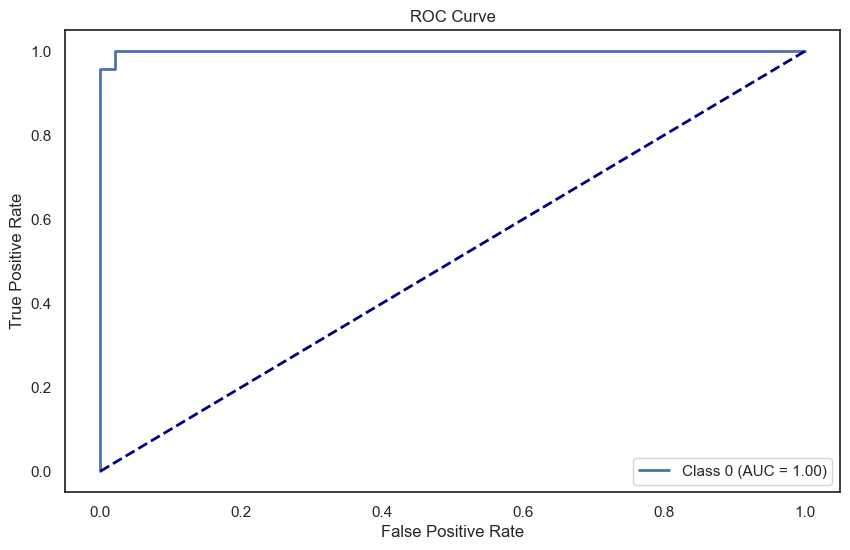

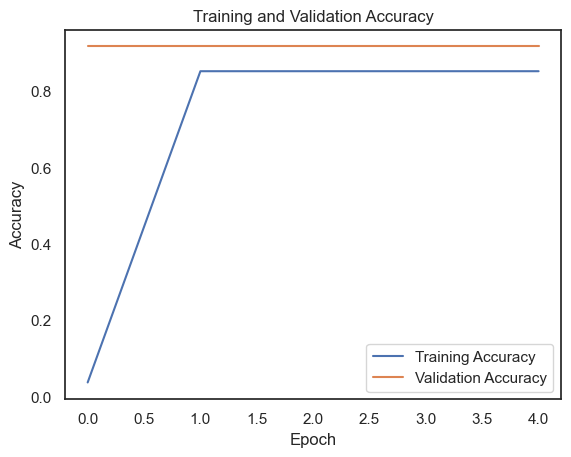

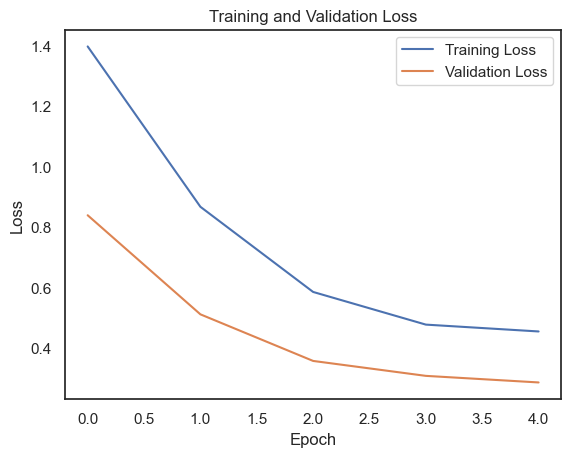

In [286]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming you have loaded your data and defined X, y_2, etc.
# ...

# Encoding the target variable
label_encoder = LabelEncoder()
y_2_encoded = label_encoder.fit_transform(y_2)

# Check the number of unique classes
num_classes = len(np.unique(y_2_encoded))

# If there is only one class, handle it differently
if num_classes == 1:
    print("Only one class found. Cannot calculate ROC curve.")

else:
    y_2_one_hot = to_categorical(y_2_encoded)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_2_one_hot, test_size=0.3, random_state=RANDOM_STATE
    )

   # Model definition
    model_ann = Sequential()
    model_ann.add(Dense(units=100, activation='relu', input_dim=X_train.shape[1]))
    model_ann.add(Dense(units=24, activation='relu'))
    model_ann.add(Dense(units=num_classes, activation='softmax'))


    # Compile the model
    model_ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Train the model and capture the history
    history = model_ann.fit(X_train, y_train, epochs=5, batch_size=544, validation_data=(X_test, y_test))


    # Train the model
    model_ann.fit(X_train, y_train, epochs=10, batch_size=544, validation_data=(X_test, y_test))
    print('Training Loss: ', history.history['loss'])
    print('Validation Loss: ', history.history['val_loss'])
    print('Training Accuracy: ', history.history['accuracy'])
    print('Validation Accuracy: ', history.history['val_accuracy'])


    # Predictions
    y_pred = model_ann.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    print(f"Accuracy: {accuracy}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    print("Confusion Matrix:")
    print(conf_matrix)

    # Classification Report
    class_report = classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    print("Classification Report:")
    print(class_report)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, lw=2, label=f'Class 0 (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()
import matplotlib.pyplot as plt

# ... (Your existing code)

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [191]:
epochs_trained = range(1, len(history.history['loss']) + 1)
print('Training Loss: ', history.history['loss'])
print('Validation Loss: ', history.history['val_loss'])
print('Training Accuracy: ', history.history['accuracy'])
print('Validation Accuracy: ', history.history['val_accuracy'])


Training Loss:  [1.0774441957473755, 0.8225783109664917, 0.75516676902771, 0.7156322002410889, 0.6594842076301575]
Validation Loss:  [0.8232268691062927, 0.7773463129997253, 0.7596457600593567, 0.6677491664886475, 0.6300559639930725]
Training Accuracy:  [0.14814814925193787, 0.2777777910232544, 0.7037037014961243, 0.7592592835426331, 0.9259259104728699]
Validation Accuracy:  [0.25, 0.5, 0.5833333134651184, 0.9166666865348816, 0.9166666865348816]
